# Autoencoder

### All Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt

from icecream import ic


from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from torch.utils.data import DataLoader, Subset

print("Imported Everything!")


Imported Everything!


### Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda


### Autoencoder Class

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, bottleneck_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)


### Loading MNIST Dataset

In [4]:
BATCH_SIZE = 64
EPOCHS = 20

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

NORMAL_DIGIT = 2024201039 % 10
train_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] == NORMAL_DIGIT]
norm_train_dataset = Subset(train_dataset, train_indices)
norm_train_loader = DataLoader(norm_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Training the Model

In [5]:
lr = 1e-3

def train_autoencoder(model, train_loader, epochs=EPOCHS, lr=lr):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.6f}")

Training with bottleneck size 4
Epoch [1/20], Loss: 0.074421
Epoch [2/20], Loss: 0.035145
Epoch [3/20], Loss: 0.028430
Epoch [4/20], Loss: 0.025582
Epoch [5/20], Loss: 0.024415
Epoch [6/20], Loss: 0.023677
Epoch [7/20], Loss: 0.023152
Epoch [8/20], Loss: 0.022719
Epoch [9/20], Loss: 0.022340
Epoch [10/20], Loss: 0.022004
Epoch [11/20], Loss: 0.021704
Epoch [12/20], Loss: 0.021436
Epoch [13/20], Loss: 0.021162
Epoch [14/20], Loss: 0.020993
Epoch [15/20], Loss: 0.020798
Epoch [16/20], Loss: 0.020634
Epoch [17/20], Loss: 0.020541
Epoch [18/20], Loss: 0.020398
Epoch [19/20], Loss: 0.020302
Epoch [20/20], Loss: 0.020228


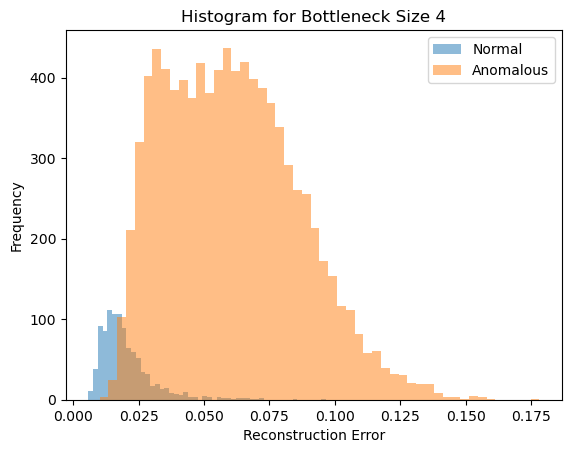

Threshold: 0.04047467
Precision: 0.9924, Recall: 0.7433, F1-score: 0.8500
Training with bottleneck size 16
Epoch [1/20], Loss: 0.076344
Epoch [2/20], Loss: 0.036304
Epoch [3/20], Loss: 0.027400
Epoch [4/20], Loss: 0.022600
Epoch [5/20], Loss: 0.019588
Epoch [6/20], Loss: 0.017573
Epoch [7/20], Loss: 0.015909
Epoch [8/20], Loss: 0.014663
Epoch [9/20], Loss: 0.013654
Epoch [10/20], Loss: 0.012857
Epoch [11/20], Loss: 0.012185
Epoch [12/20], Loss: 0.011624
Epoch [13/20], Loss: 0.011118
Epoch [14/20], Loss: 0.010674
Epoch [15/20], Loss: 0.010263
Epoch [16/20], Loss: 0.009923
Epoch [17/20], Loss: 0.009626
Epoch [18/20], Loss: 0.009401
Epoch [19/20], Loss: 0.009186
Epoch [20/20], Loss: 0.009025


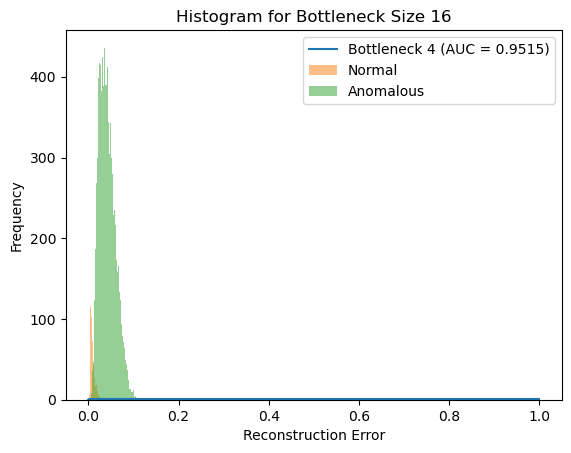

Threshold: 0.021184716
Precision: 0.9937, Recall: 0.8908, F1-score: 0.9394
Training with bottleneck size 32
Epoch [1/20], Loss: 0.072556
Epoch [2/20], Loss: 0.036400
Epoch [3/20], Loss: 0.028631
Epoch [4/20], Loss: 0.023477
Epoch [5/20], Loss: 0.020350
Epoch [6/20], Loss: 0.017778
Epoch [7/20], Loss: 0.015368
Epoch [8/20], Loss: 0.013714
Epoch [9/20], Loss: 0.012576
Epoch [10/20], Loss: 0.011764
Epoch [11/20], Loss: 0.011103
Epoch [12/20], Loss: 0.010552
Epoch [13/20], Loss: 0.010088
Epoch [14/20], Loss: 0.009700
Epoch [15/20], Loss: 0.009346
Epoch [16/20], Loss: 0.009010
Epoch [17/20], Loss: 0.008724
Epoch [18/20], Loss: 0.008439
Epoch [19/20], Loss: 0.008219
Epoch [20/20], Loss: 0.007982


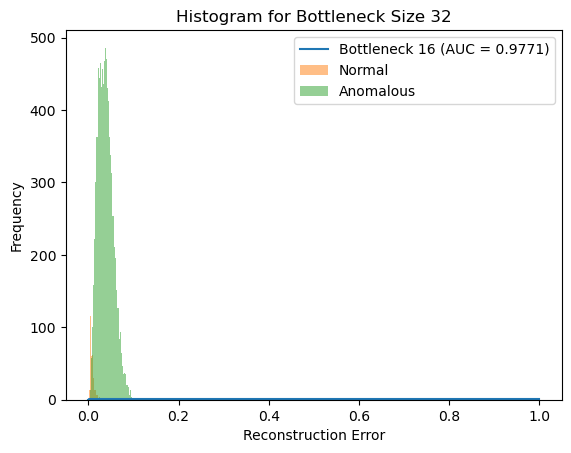

Threshold: 0.018840019
Precision: 0.9937, Recall: 0.8896, F1-score: 0.9387


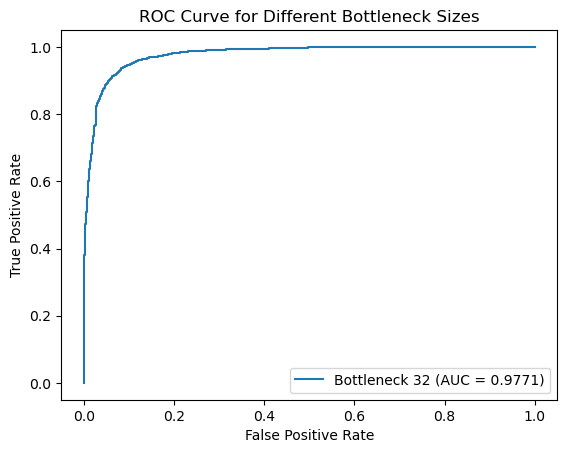

In [6]:
BOTTLENECK_SIZES = [4, 16, 32]

def compute_reconstruction_errors(model, data_loader):
    model.eval()
    errors, labels = [], []
    criterion = nn.MSELoss(reduction='none')
    
    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.to(device)
            outputs = model(images)

            loss = criterion(outputs, images)
            loss = loss.view(loss.shape[0], -1).mean(dim=1)  # per-image MSE loss
            errors.extend(loss.cpu().numpy())
            labels.extend(lbls.numpy())
    return np.array(errors), np.array(labels)

for bottleneck in BOTTLENECK_SIZES:
    print(f"Training with bottleneck size {bottleneck}")
    model = AutoEncoder(bottleneck).to(device)
    train_autoencoder(model, norm_train_loader)
    
    torch.save(model.state_dict(), f"autoencoder_bottleneck_{bottleneck}.pth")
    
    errors, labels = compute_reconstruction_errors(model, test_loader)
    
    plt.hist(errors[labels == NORMAL_DIGIT], bins=50, alpha=0.5, label='Normal')
    plt.hist(errors[labels != NORMAL_DIGIT], bins=50, alpha=0.5, label='Anomalous')
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Histogram for Bottleneck Size {bottleneck}")
    plt.show()
    
    threshold = np.percentile(errors[labels == NORMAL_DIGIT], 95)
    print("Threshold:", threshold)
    predictions = errors > threshold
    ground_truth = labels != NORMAL_DIGIT
    
    precision, recall, f1, _ = precision_recall_fscore_support(ground_truth, predictions, average='binary')
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    
    fpr, tpr, _ = roc_curve(ground_truth, errors)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Bottleneck {bottleneck} (AUC = {roc_auc:.4f})')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Different Bottleneck Sizes")
plt.legend()
plt.show()


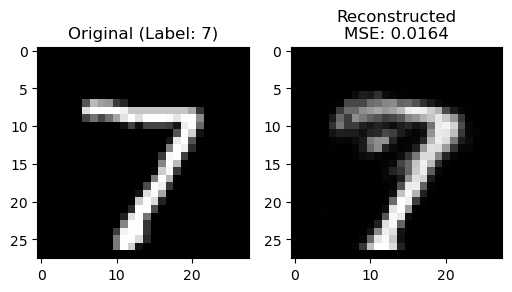

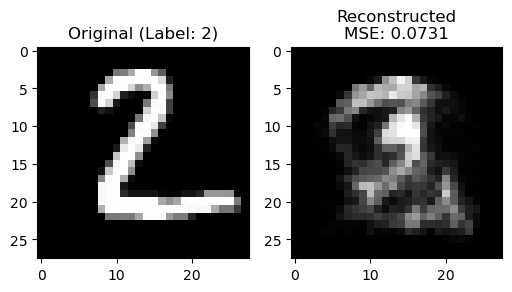

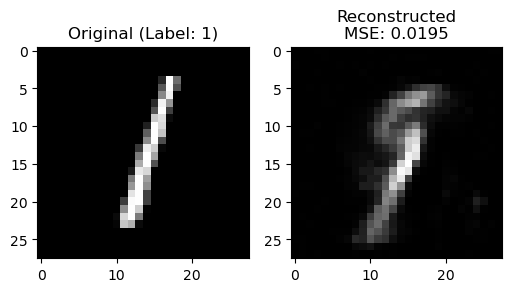

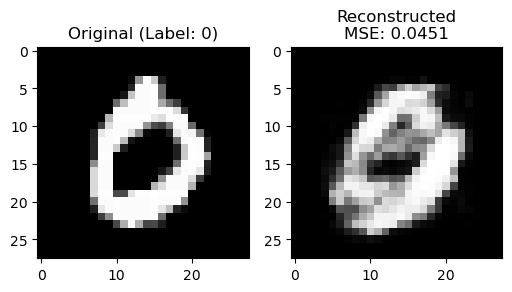

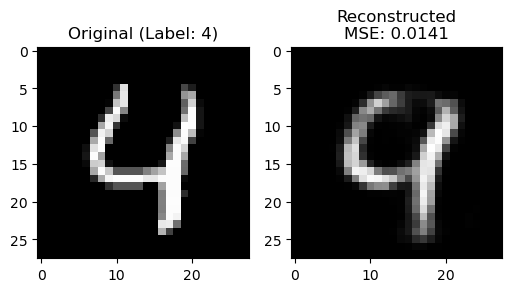

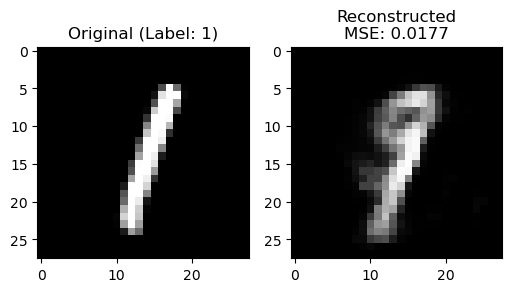

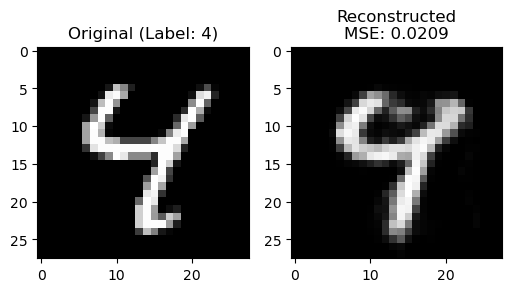

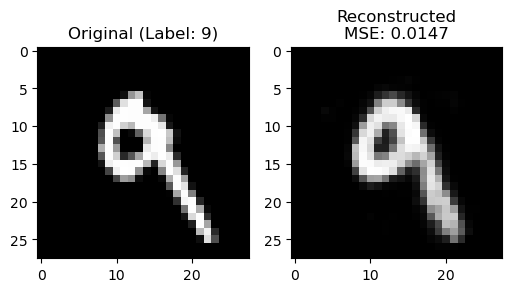

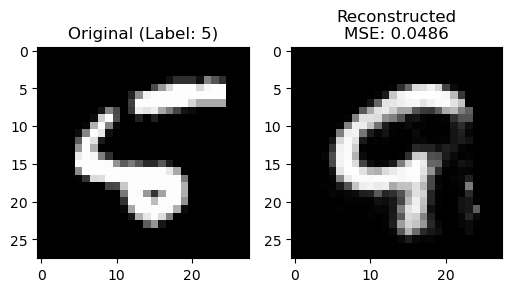

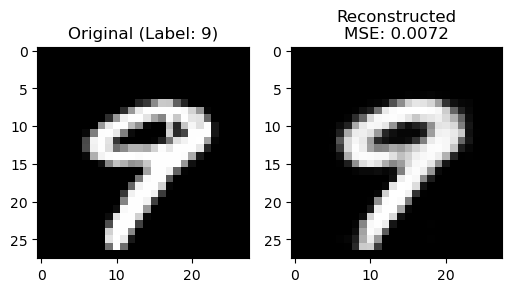

In [7]:
import matplotlib.pyplot as plt
import torch

def test_single_digit(model, test_loader, index=0):
    model.eval()
    images, labels = next(iter(test_loader))
    image = images[index].unsqueeze(0).to(device)
    
    with torch.no_grad():
        reconstructed = model(image)

    image = image.cpu().squeeze().numpy()
    reconstructed = reconstructed.cpu().squeeze().numpy()
    
    mse_loss = ((image - reconstructed) ** 2).mean()
    
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(image, cmap="gray")
    axs[0].set_title(f"Original (Label: {labels[index].item()})")
    
    axs[1].imshow(reconstructed, cmap="gray")
    axs[1].set_title(f"Reconstructed\nMSE: {mse_loss:.4f}")
    
    plt.show()

for i in range(10):
    test_single_digit(model, test_loader, index=i)